# Modèle de classification - Resnet50

## Importation des packages

In [1]:
import util

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from torch.autograd import Variable

import cv2

## Instanciation des transformations de données

In [2]:
transformes = util.get_transform() # Pour modifier les transformations et afin de garantir que ces mêmes transformations soit appliquées lors de l'extraction des bndbox, il faut modifier cette fonction dans util.py

## Création du dataset

In [3]:
dataset = util.VaidVehiculeDataset_test('labels.csv', 'bbox_imgs', transformes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


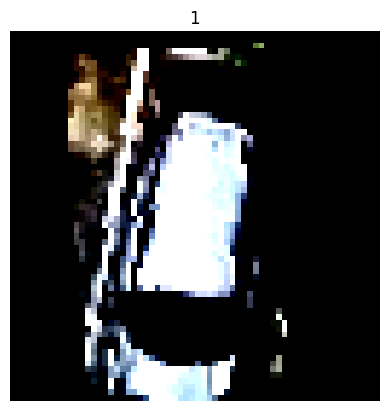

In [4]:
rnd_inds=np.random.randint(0,len(dataset))
img, lab = dataset[rnd_inds]
img.shape
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.title(lab)
plt.axis('off')
plt.show()

In [5]:
len_img=len(dataset)
len_train=int(0.8*len_img)
len_val=len_img-len_train

train,val = random_split(dataset,
                             [len_train,len_val])

print("train dataset size:", len(train))
print("validation dataset size:", len(val))

train dataset size: 38882
validation dataset size: 9721


In [6]:
train_dl = DataLoader(train,
                      batch_size=32,
                      shuffle=True)

val_dl = DataLoader(val,
                    batch_size=32,
                    shuffle=False)

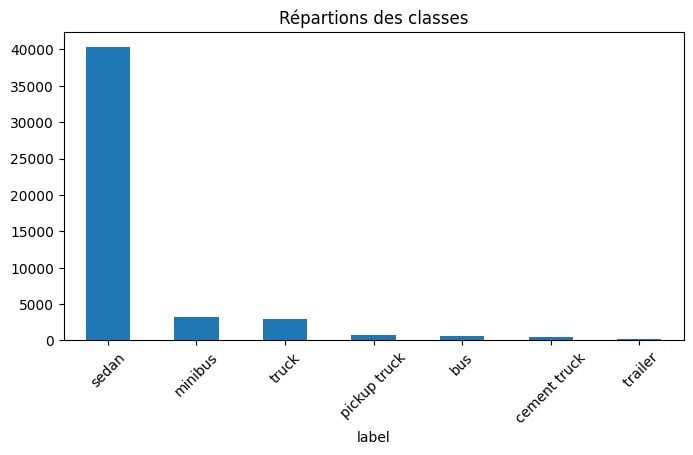

In [7]:
classes = ['sedan' , 'minibus' , 'truck' , 'pickup truck' , 'bus' , 'cement truck' , ' trailer']


plt.figure(figsize= (8,4))
pd.read_csv('labels.csv')['label'].value_counts().plot(kind = "bar");
plt.xticks(np.arange(7), classes, rotation=45)
plt.title('Répartions des classes');

### Aperçu d'un batch d'entrainement

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


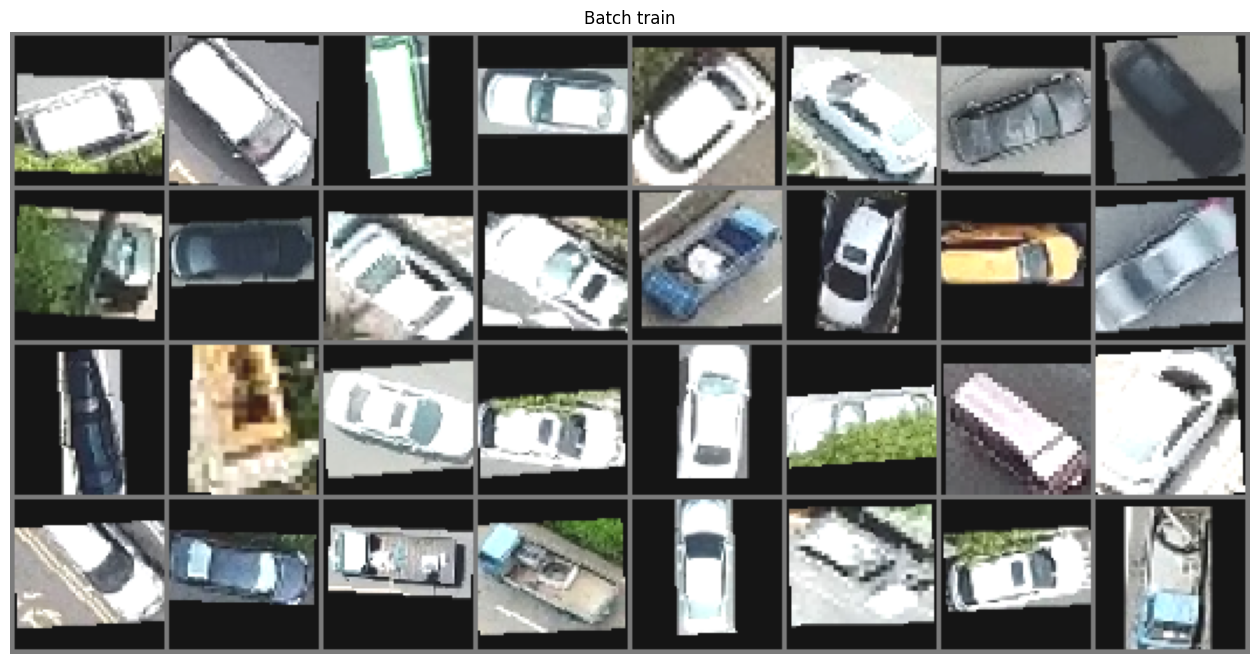

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

std=torch.Tensor([0.229, 0.224, 0.225])
mean=torch.Tensor([0.485, 0.456, 0.406])

def denorm(img):
    return img*std[0]+mean[0]

def show_batch(loader):
    for img,_ in loader:
        plt.figure(figsize=(16,16))
        plt.imshow(denorm(make_grid(img,8)).permute(1,2,0))
        plt.axis(False);
        plt.title('Batch train')
        break

show_batch(train_dl)

### Entrainement du modèle

In [9]:
num_classes = len(classes)
device = 'cuda'
# Création du modèle
model = util.Classifier(num_classes, pretrained=False)
model.to(device)
learning_rate = 0.001
results = util.classification_train(model, train_dl, val_dl, device, learning_rate = learning_rate, num_epochs=50)

c:\ProgramData\anaconda3\envs\test2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\test2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Learning Rate: 0.001
Epoch 1/50, Accuracy: 84.58%
Epoch 2, Learning Rate: 0.001
Epoch 2/50, Accuracy: 87.25%
Epoch 3, Learning Rate: 0.001
Epoch 3/50, Accuracy: 83.53%
Epoch 4, Learning Rate: 0.001
Epoch 4/50, Accuracy: 90.69%
Epoch 5, Learning Rate: 0.001
Epoch 5/50, Accuracy: 84.21%
Epoch 6, Learning Rate: 0.001
Epoch 6/50, Accuracy: 88.15%
Epoch 7, Learning Rate: 0.001
Epoch 7/50, Accuracy: 91.11%
Epoch 8, Learning Rate: 0.001
Epoch 8/50, Accuracy: 90.99%
Epoch 9, Learning Rate: 0.001
Epoch 9/50, Accuracy: 90.10%
Epoch 10, Learning Rate: 0.001
Epoch 10/50, Accuracy: 94.29%
Epoch 11, Learning Rate: 0.001
Epoch 11/50, Accuracy: 94.14%
Epoch 12, Learning Rate: 0.001
Epoch 12/50, Accuracy: 93.49%
Epoch 13, Learning Rate: 0.001
Epoch 13/50, Accuracy: 95.65%
Epoch 14, Learning Rate: 0.001
Epoch 14/50, Accuracy: 95.05%
Epoch 15, Learning Rate: 0.001
Epoch 15/50, Accuracy: 94.91%
Epoch 16, Learning Rate: 0.001
Epoch 16/50, Accuracy: 95.85%
Epoch 17, Learning Rate: 0.001
Epoch 17/50

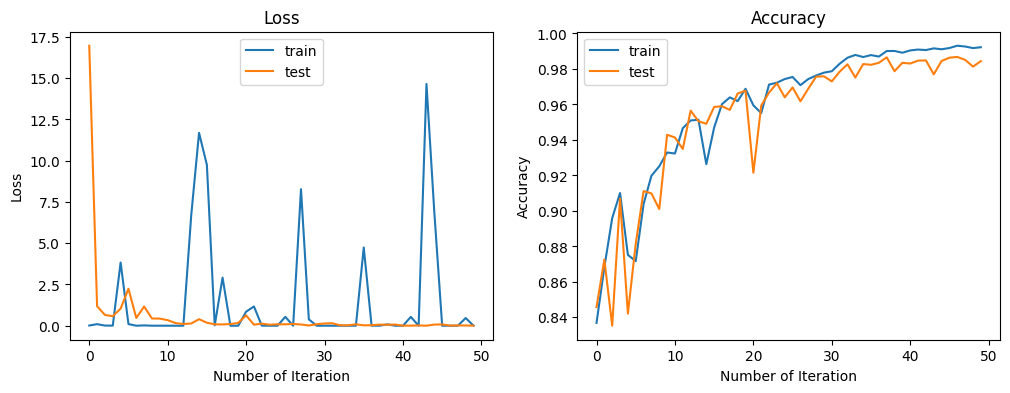

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(np.arange(len(results)),results['train_Loss'], label = 'train')
plt.plot(np.arange(len(results)),results['val_Loss'], label = 'test')
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()

plt.subplot(122)
plt.plot(np.arange(len(results)),results['train_Accuracy'], label = 'train')
plt.plot(np.arange(len(results)),results['val_Accuracy'], label = 'test')
plt.xlabel("Number of Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.show()

## Prédiction 

In [11]:
device = 'cuda'
def prediction(index, data):
    img, _ = data[index]
    img = img.to(device)
    img = Variable(img.view([-1, 3, 64, 64]))
    outputs = model(img)
    predict = torch.max(outputs.data, 1)[1].to(device)
    
    return predict

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Predicted Label: 1')

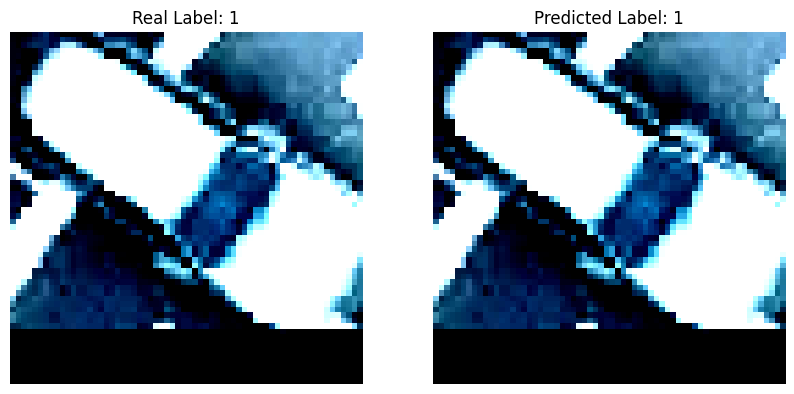

In [39]:
rnd_inds=np.random.randint(0,len(dataset))

fig = plt.figure(figsize=(10, 7))

img, label = dataset[rnd_inds]
predicted_label = prediction(rnd_inds, dataset)

fig.add_subplot(1, 2, 1)
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title("Real Label: " + str(label))

fig.add_subplot(1,2,2)
plt.imshow(img.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title("Predicted Label: " + str(int(predicted_label)+1))


## Evaluation du modèle sur les données de test

In [13]:
model.eval()

#prédictions du modèle sur le données de test
predictions = []
targets = []
with torch.no_grad():
    for images, labels in val_dl: 
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy() + 1)
        targets.extend(labels.cpu().numpy())

In [14]:
from sklearn.metrics import confusion_matrix

# Convertissez les prédictions et les étiquettes en tableaux numpy
predictions = np.array(predictions)
targets = np.array(targets)

# Créez la matrice de confusion
confusion_mat = confusion_matrix(targets, predictions)

In [15]:
from sklearn.metrics import classification_report

print(classification_report(targets, predictions, target_names=["Sedan", "Minibus", "Truck", "Pickuo Truck", "Bus", "Ciment Truck", "Trailer"]))

              precision    recall  f1-score   support

       Sedan       0.99      0.99      0.99      8050
     Minibus       0.91      0.90      0.90        99
       Truck       0.94      0.94      0.94       672
Pickuo Truck       0.93      0.97      0.95       582
         Bus       0.94      0.89      0.91       124
Ciment Truck       1.00      0.85      0.92        46
     Trailer       0.96      0.92      0.94       148

    accuracy                           0.98      9721
   macro avg       0.95      0.92      0.94      9721
weighted avg       0.98      0.98      0.98      9721



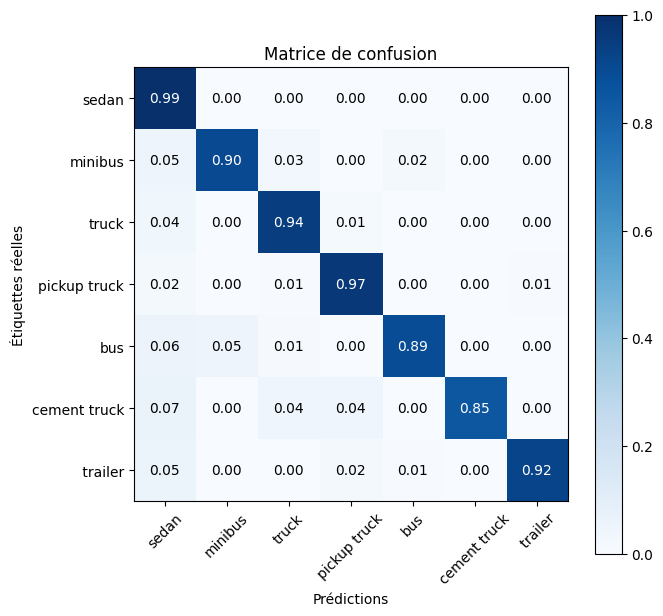

In [16]:
# Affichez la matrice de confusion normalisée
confusion_mat_norm = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(num_classes, num_classes))
plt.imshow(confusion_mat_norm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(confusion_mat_norm[i, j], '.2f'),
                 ha="center", va="center",
                 color="white" if confusion_mat_norm[i, j] > 0.5 else "black")

plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel("Prédictions")
plt.ylabel("Étiquettes réelles")
plt.title("Matrice de confusion")

plt.show()

### Sauvergarde des poids du modèle

In [17]:
torch.save(model.state_dict(),"classifier.pth")
